### Tutorial 10

We will continue with the example of [section 6.3](https://nbviewer.jupyter.org/github/willienicol/Biochemical-engineering-notes/blob/master/6%20Modeling%20stoichiometry%20variations/Oxygen%20starvation%20in%20batch%20fermenters.ipynb). Below the physiological properties of the microbe as given before:

|$\alpha \qquad \qquad$|$\gamma \qquad \qquad $|$\mu_{max} \qquad$|$\theta_{max}\qquad$| $(P/O)$ $\qquad \qquad$
|----|-|-|-|-
|$\frac{cmol\,CO_2}{cmol \, X}$|$\frac{mol \, ATP}{Cmol \, X}$|$\frac{1}{h}$|$\frac{mol \, ATP}{cmol\,X\cdot h}$|$\frac{mol\,ATP}{mol\, O}$
|0.1|2.5|0.3|0.1|1.5

The biomass formula is given by $CH_{1.8}O_{0.5}N_{0.2}$

The following Monod characteristics are known:

|$K_M\left[\frac{mg}{L} \right] \qquad$ |
 -|-
 **Growth**|30 
**Maintenance**|5 

Since only $CO_2$ will be formed as product, zero product inhibition is present. The following conditions are specified for the batch fermenter:

|V [$L$]|$C_X^o \left[ \frac{g}{L}\right]$|$C_S^o \left[ \frac{g}{L}\right]$
|-------------|-------|------
|2000|0.025 $\qquad$|150 $\qquad$

We can now define the parameters:

In [1]:
import numpy
from numpy import interp, asarray, argmax
import matplotlib.pyplot as plt
%matplotlib notebook 
from scipy.integrate import odeint
alpha, gamma, mu_max, theta_max, PO = 0.1, 2.5, 0.3, 0.1, 1.5
Km_mu, Km_theta = 30/1000/30, 5/1000/30
Mx=12+1.8+0.5*16+0.2*14
V, Cxo, Cso = 200, 0.025/Mx, 150/30

We can also define $k_La$ and $C_{O_2}^{sat}$ as 200$\frac{1}{h}$ and 7$\frac{mg}{L}$: 

In [2]:
kla=200
Co_s_max=7/1000/32  #mol/l

The flux model is given below. Note that carbon splits between biomass and respiration.

<img src="respv2.png" width="700" />

In [112]:
def response_fun(C):
    
    Cs, Cx, Co = C          
    mu=mu_max*Cs/(Km_mu+Cs)
    theta=theta_max*Cs/(Km_theta+Cs)
    
    ro_mt=kla*Co_s_max
    
    Sbase = numpy.matrix([[-1,1.1,1,0,0],   #Stoichiometric matrix without specification (4x5)
                         [0,0.1,1,0,-1],
                         [0,0.1,2,-2,0],
                         [0,-2.5,2/3,3,0]])
    
    S1 = numpy.vstack([Sbase,[0,1,0,0,0]])  #Stoich matrix with growth spec
      
    C= numpy.matrix([[0,0,0,theta, mu]]).T
    r = numpy.linalg.solve(S1,C)            #rates for regime where no oxygen limitation exist
    
        
    if ro_mt > r[3,0]*Cx:     #no oxygen limitation

        
        return [-r[0,0],
                r[1,0],      #biomass 
                r[3,0],      # O2 consumption
                r[4,0]]     # CO2 formation  
        
     
    else:
        
        S2 = numpy.vstack([Sbase,[0,0,0,1,0]])          #Stoich matrix with oxygen spec

        C2= numpy.matrix([[0,0,0,theta,ro_mt/Cx]]).T   # Note the ro specification!!
        r2 = numpy.linalg.solve(S2,C2)                 # rates for regime where oxygen limitation exist
        
        
        return [-r2[0,0],
                r2[1,0],
                r2[3,0],    #O2 consumption 
                r2[4,0]]     #CO2 formation

In [101]:
def ferm_eq(C,t):
    Cs, Cx = C[0],C[1]
    r=response_fun([Cs, Cx, 0])     
    
    return [r[0]*Cx,
            r[1]*Cx,
            r[2]*Cx]    

<IPython.core.display.Javascript object>


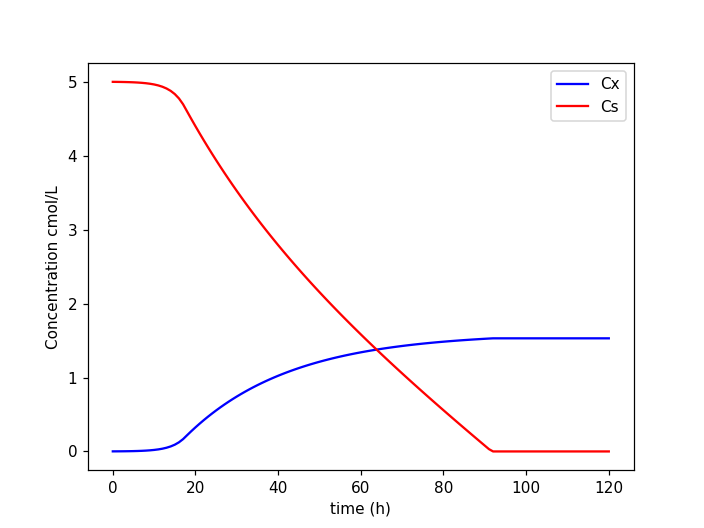

In [102]:
Co=[Cso, Cxo,0]                     # [Cxo, Cso, Cgo, Ceo] in cmol/L
tmax=120                                 # Integrate for 20 hours  
tspan=numpy.linspace(0,tmax,121)           # define the timespan of the integration
Ci = odeint(ferm_eq, Co, tspan)             # integration via odeint that calls apon ferm_eq

Cs=Ci[:,0]
Cx=Ci[:,1]                                  

plt.figure(2)
plt.plot(tspan, Cx, color='blue', label='Cx')
plt.plot(tspan, Cs, color='red', label='Cs')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (h)') 
plt.show()

a) Determine $[\mu, -r_S, r_{O_2}]$ at 10, 30 and 90 hours. Explain the differences.

(Tip: redefine tspan with 121 elements so that the index corresponds to the time value)

b) What is the minimum value of $r_{O_2}$ for a cell to survive? No integration required. $[0.0272 \frac{mol}{cmol \, X \cdot h}]$

(Tip: Copy the matrix from the response function, alter accordingly and solve the matrix manually (not using any functions).

c) Given the value in (b), that is the maximum possible $C_X$ that the fermenter can sustain. $[1.604 \frac{cmol}{L}]$

(Tip: $r_{O_2}^{mt}=r_{O_2}^V=r_{O_2}C_X$)

d) How does the answer in (c) compare to the final $C_X$ achieved in the fermentation? 

e) Play around by increasing $C_{S}^o$ and the fermentation time. Does the final $C_X$ get closer to the maximum value in (c)?

f) At what point in time is the maximum volumetric supply of oxygen fully utilised? [approx 17 hours]

g) Plot $\mu$ as a function of time. Explain the profile.

h) Determine the fraction of glucose spent on growth at 18 and 80 hours. [94% and 17%]

i) Increase the value of $k_La$ to 600 $\frac{1}{h}$ an plot the results against the original profiles. Explain the difference.



In [103]:
#A

rate10 = response_fun([Cs[10], Cx[10],0])
print("10 hours", [-rate10[0],rate10[1],rate10[3]])

rate30 = response_fun([Cs[30], Cx[30],0])
print("30 hours", [-rate30[0],rate30[1],rate30[3]])

rate90 = response_fun([Cs[90], Cx[90],0])
print("90 hours", [-rate90[0],rate90[1],rate90[3]])

10 hours [0.54943935851783732, 0.29993958302259222, 0.23450279634411547]
30 hours [0.10696262736167078, 0.045775618235495051, 0.058898228214400987]
90 hours [0.030975558365609709, 0.0021600862126933047, 0.028707467842281745]


In [104]:
#B

Sbase_b = numpy.matrix([[-1,1.1,1,0,0],   #Stoichiometric matrix without specification (4x5)
                         [0,0.1,1,0,-1],
                         [0,0.1,2,-2,0],
                         [0,-2.5,2/3,3,0]])

S1_b = numpy.vstack([Sbase_b,[0,1,0,0,0]])  #Stoich matrix with growth spec

C_b= numpy.matrix([[0,0,0,theta_max, 0]]).T
r_b = numpy.linalg.solve(S1_b,C_b) 
answer_b = float(r_b[3])
answer_b

0.027272727272727275

In [105]:
#C

ro_mt=kla*Co_s_max

Cx_max_c = ro_mt/answer_b
Cx_max_c

1.6041666666666667

In [106]:
#D

Cx_max_d = Cx[120]
Cx_max_d

1.5301657595508849

In [116]:
#F
    
O_vrate = numpy.asarray([ferm_eq(C, 0) for C in Ci])[:,2]

numpy.where(abs(O_vrate-ro_mt)<0.00001)[0][0]

18

<IPython.core.display.Javascript object>


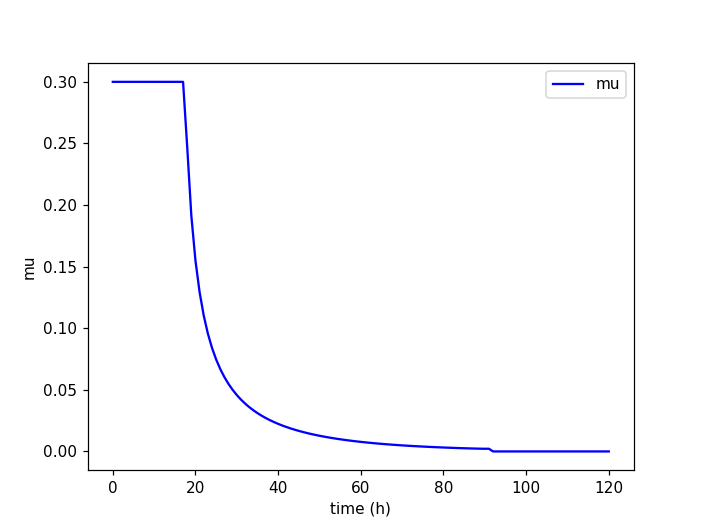

In [109]:
#G

some_rates = numpy.asarray([response_fun(C) for C in Ci])

X_rate = some_rates[:,1]

plt.figure(5)
plt.plot(tspan, X_rate, color='blue', label='mu')
#plt.plot(tspan, Cs, color='red', label='Cs')
plt.legend(loc='best')
plt.ylabel('mu') 
plt.xlabel('time (h)') 
plt.show()

In [113]:
def response_fun1(C):
    
    Cs, Cx, Co = C          
    mu=0
    theta=theta_max*Cs/(Km_theta+Cs)
    
    ro_mt=kla*Co_s_max
    
    Sbase = numpy.matrix([[-1,1.1,1,0,0],   #Stoichiometric matrix without specification (4x5)
                         [0,0.1,1,0,-1],
                         [0,0.1,2,-2,0],
                         [0,-2.5,2/3,3,0]])
    
    S1 = numpy.vstack([Sbase,[0,1,0,0,0]])  #Stoich matrix with growth spec
      
    C= numpy.matrix([[0,0,0,theta, mu]]).T
    r = numpy.linalg.solve(S1,C)            #rates for regime where no oxygen limitation exist
      
    return [-r[0,0],
            r[1,0],      #biomass 
            r[3,0],      # O2 consumption
            r[4,0]]     # CO2 formation  

In [115]:
#H

S_rate = some_rates[:,0][18]

S_rate1 = numpy.asarray([response_fun1(C) for C in Ci])[:,0][18]

percentage = (-S_rate+S_rate1)/(-S_rate)
percentage

0.9404035944906789

In [ ]:
"question I just change Kla value to 600 then compare graphs of concetration"

kla=600
Co=[Cxo, Cso]                     # [Cxo, Cso, Cgo, Ceo] in cmol/L
tmax=120                                   # Integrate for 20 hours  
tspan=numpy.linspace(0,tmax,121)           # define the timespan of the integration
Ci = odeint(ferm_eq, Co, tspan)             # integration via odeint that calls apon ferm_eq

Cx=Ci[:,0]                                  
Cs=Ci[:,1]


plt.figure(5)
plt.plot(tspan, Cx, color='blue', label='Cx')
plt.plot(tspan, Cs, color='red', label='Cs')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (h)') 
plt.show()
